### Dendrogram and correlation lists

Here we will work not with our model, but with actual data itself. We will try to get correlations out of it, that can, potentialy, help us to get rid of some redundancy and just understand our data better.

### Prepare

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from scipy.cluster import hierarchy as hc

In [3]:
from fastai.tabular import *

In [4]:
from fastai import tabular

In [5]:
from exp.nb_ import *

In [6]:
path=Path('../data/football/')

In [7]:
train_df = pd.read_pickle(path/'trans_over_1000_final.pkl')

In [8]:
cat_vars_tpl = ('season','trs_year','trs_month','trs_day','trs_till_deadline',
            'contract_left_months', 'contract_left_years','age',
            'is_midseason','is_loan','is_end_of_loan',
            'nat_national_name','plr_position_main',
            'plr_other_positions','plr_nationality_name',
            'plr_other_nationality_name','plr_place_of_birth_country_name',
            'plr_foot','plr_height','plr_player_agent','from_club_name','from_club_is_first_team',
            'from_clb_place','from_clb_qualified_to','from_clb_is_champion','from_clb_is_cup_winner',
            'from_clb_is_promoted','from_clb_lg_name','from_clb_lg_country','from_clb_lg_group',
            'from_coach_name', 'from_sport_dir_name',
            'to_club_name','to_club_is_first_team','to_clb_place','to_clb_qualified_to',
            'to_clb_is_champion','to_clb_is_cup_winner','to_clb_is_promoted','to_clb_lg_name','to_clb_lg_country',
            'to_clb_lg_group','to_coach_name', 'to_sport_dir_name',
            'plr_position_0','plr_position_1','plr_position_2',
            'stats_leag_name_0','stats_leag_grp_0','stats_leag_name_1','stats_leag_grp_1','stats_leag_name_2',
            'stats_leag_grp_2')
cont_vars_tpl = ('nat_months_from_debut','nat_matches_played','nat_goals_scored','from_clb_pts_avg',
             'from_clb_goals_diff_avg','to_clb_pts_avg','to_clb_goals_diff_avg','plr_apps_0',
             'plr_apps_1','plr_apps_2','stats_made_goals_0','stats_conc_gols_0','stats_cards_0',
             'stats_minutes_0','stats_team_points_0','stats_made_goals_1','stats_conc_gols_1',
             'stats_cards_1','stats_minutes_1','stats_team_points_1','stats_made_goals_2',
             'stats_conc_gols_2','stats_cards_2','stats_minutes_2','stats_team_points_2', 'pop_log1p')

In [9]:
cat_vars = list(cat_vars_tpl)
cont_vars = list(cont_vars_tpl)
all_vars = cat_vars + cont_vars

In [10]:
dep_var = 'fee'

In [11]:
df = train_df[all_vars + [dep_var]].copy()

In [12]:
np.random.seed(1001)
ln = len(df)
valid_idx = np.random.choice(ln, int(ln*0.2), replace=False)

In [13]:
procs=[FillMissing, Categorify, Normalize]

In [14]:
min_log_y = np.log(500)
max_log_y = np.log(np.max(df[dep_var])*1.2)
y_range = torch.tensor([min_log_y, max_log_y], device=defaults.device)

In [15]:
BS = 128

In [16]:
def emb_sz_rule_reduced(n_cat:int)->int: return min(10, round(1.6 * n_cat**0.56))

In [17]:
#monkey pacth embenning rule as 600 floats is too much for our case
tabular.data.emb_sz_rule = emb_sz_rule_reduced

In [18]:
name = 'w_pop_ref-346-median'

In [19]:
p = ld_var(name=f'{name}_hypers', path=path)
p

{'layers': [1000, 500],
 'layers_drop': [0.07, 0.7],
 'emb_drop': 0.7,
 'cycles': 40,
 'w_decay': 0.7,
 'max_lr': 0.001}

In [20]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
        .databunch(bs=BS))

In [21]:
np.random.seed(1001)
learn = tabular_learner(data, 
                        layers=p['layers'], 
                        ps=p['layers_drop'], 
                        emb_drop=p['emb_drop'], 
                        y_range=y_range, 
                        metrics=exp_mmape,
                        loss_func=MAELossFlat())

In [22]:
learn = learn.load(f'{name}')

### Plot

I use here `Cramers V` statistic to determine correlation because my experiments showed me that more simple 
(and muuuuch fast) `Spearman rank-order correlation` algorithm doesn't work well for categorical columns in many cases.  
As an ex.: if you add another column of categorical data, but assign categorical differently (let's randomize order in category dictionary) these column should have 100% correlation, but that's not the case for `spearmanr`.  
So I've shifted to more sophisticated analysis algorithm `Cramers V`.  
Also it can handle NA values without manual preprocessing.

In [25]:
np.set_printoptions(threshold=800, suppress=True)

Here we calculate correlation matrix separately as it can be pretty long process.
And then we can use it in different views.

In [26]:
corr_v = get_cramer_v_matr(df[all_vars])

Total time: 20:15


In [28]:
sv_var(corr_v, 'corr_v', path)

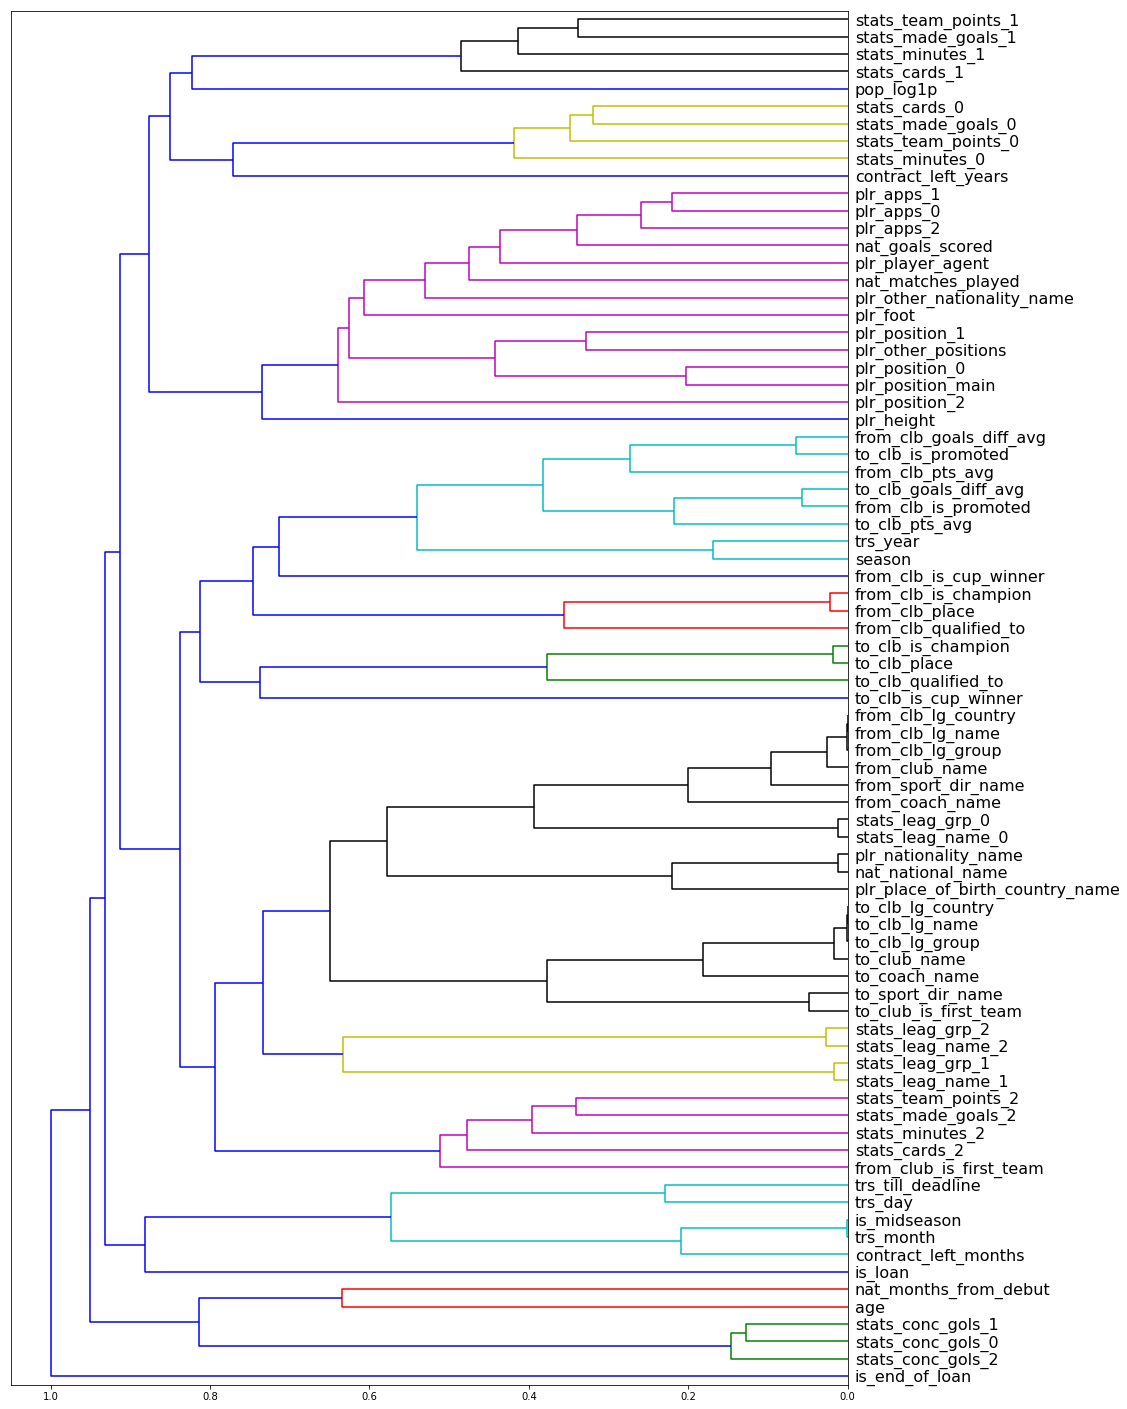

In [30]:
plot_dendrogram_corr(corr_v, df[all_vars].columns)

In [31]:
get_top_corr_dict(df[all_vars], corr_thr=0.9, corr_matr=corr_v)

OrderedDict([('from_clb_lg_name vs from_clb_lg_country', 1.0),
             ('to_clb_lg_name vs to_clb_lg_country', 1.0),
             ('to_clb_lg_name vs to_clb_lg_group', 1.0),
             ('to_clb_lg_country vs to_clb_lg_group', 1.0),
             ('trs_month vs is_midseason', 0.999),
             ('from_clb_lg_name vs from_clb_lg_group', 0.999),
             ('from_clb_lg_country vs from_clb_lg_group', 0.999),
             ('nat_national_name vs plr_nationality_name', 0.988),
             ('stats_leag_name_0 vs stats_leag_grp_0', 0.988),
             ('to_club_name vs to_clb_lg_name', 0.983),
             ('to_club_name vs to_clb_lg_country', 0.983),
             ('to_club_name vs to_clb_lg_group', 0.983),
             ('to_clb_place vs to_clb_is_champion', 0.982),
             ('stats_leag_name_1 vs stats_leag_grp_1', 0.982),
             ('from_clb_place vs from_clb_is_champion', 0.978),
             ('from_club_name vs from_clb_lg_name', 0.974),
             ('from_club_name vs

### Features closeness and dimension reduction

The last thing we do is to visualize the embeddings vectors.
For that we should reduce it's dimension to 2 as I wasn't able to plot 10-dimensions vector on a flat screen :)

In [23]:
emb_map = get_embs_map(learn=learn)

In [24]:
redc_emb_map = emb_map_reduce_dim(embs_map=emb_map, outp_dim=2, to_df=True)

In [25]:
redc_emb_map = add_times_col(embs_map=redc_emb_map, df=df)

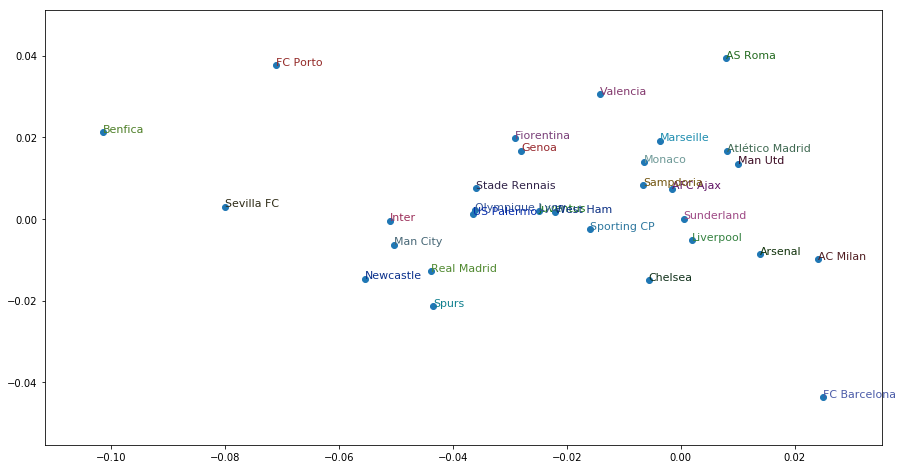

In [30]:
plot_2d_emb(emb_map=redc_emb_map, feature='from_club_name', top_x=30)

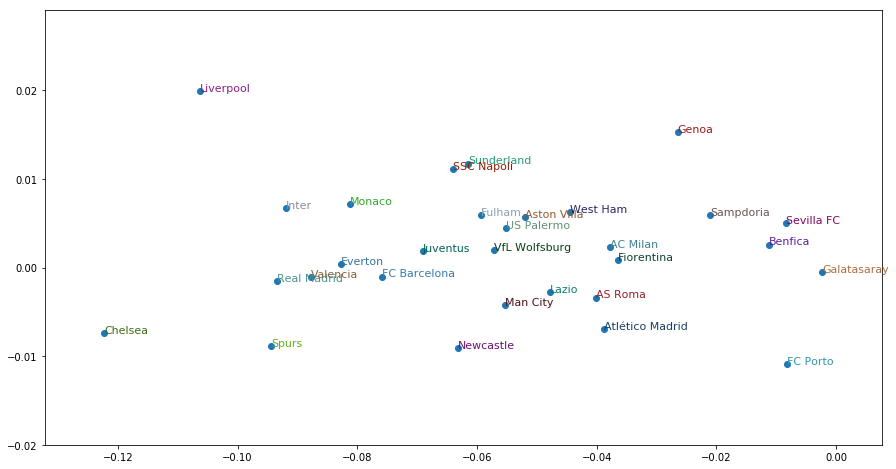

In [29]:
plot_2d_emb(emb_map=redc_emb_map, feature='to_club_name', top_x=30)

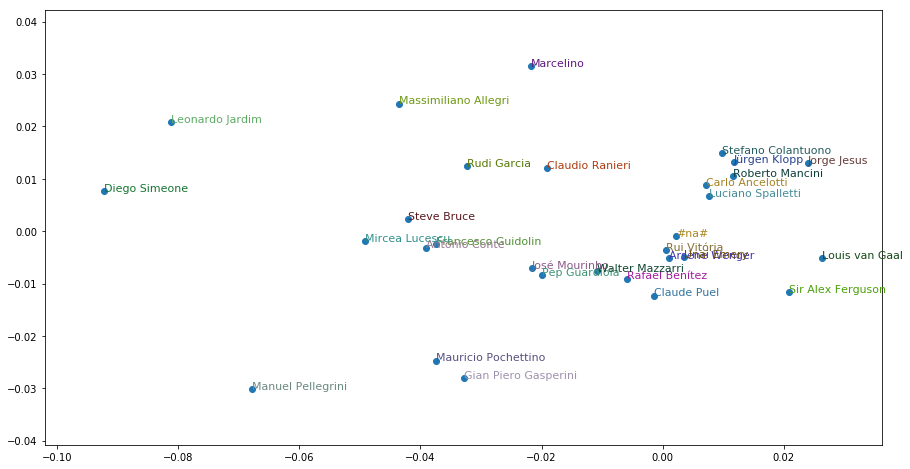

In [27]:
plot_2d_emb(emb_map=redc_emb_map, feature='from_coach_name', top_x=30)

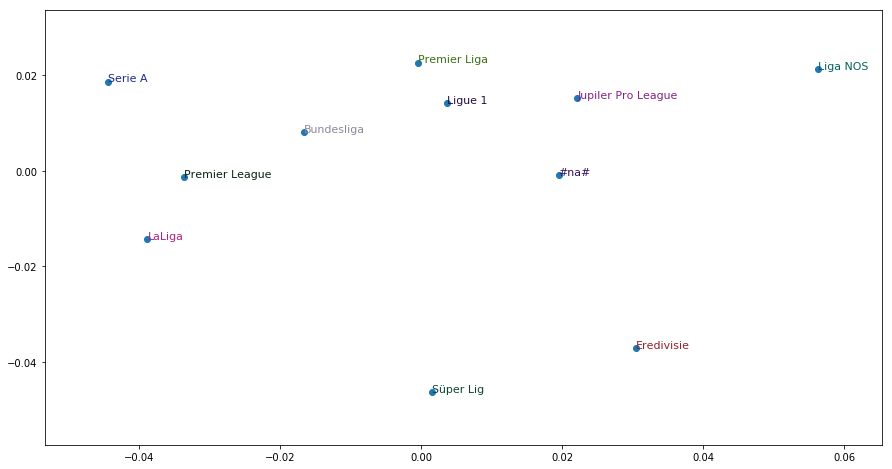

In [28]:
plot_2d_emb(emb_map=redc_emb_map, feature='from_clb_lg_name', top_x=30)

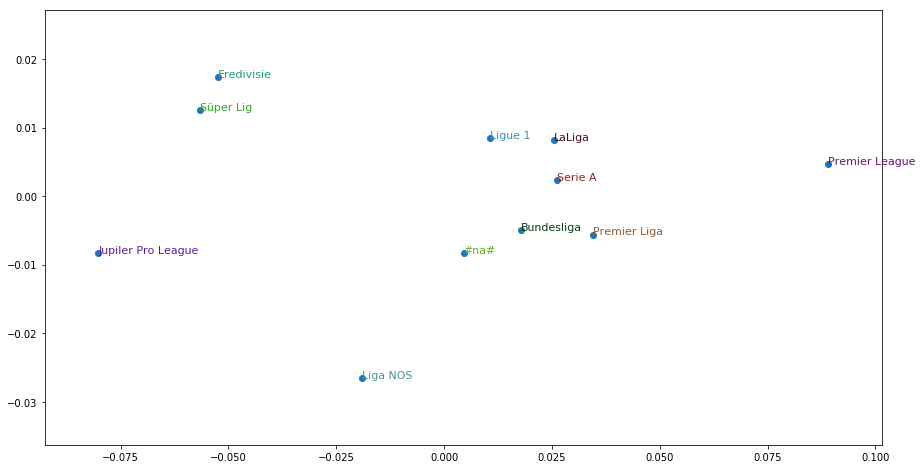

In [29]:
plot_2d_emb(emb_map=redc_emb_map, feature='to_clb_lg_name', top_x=30)

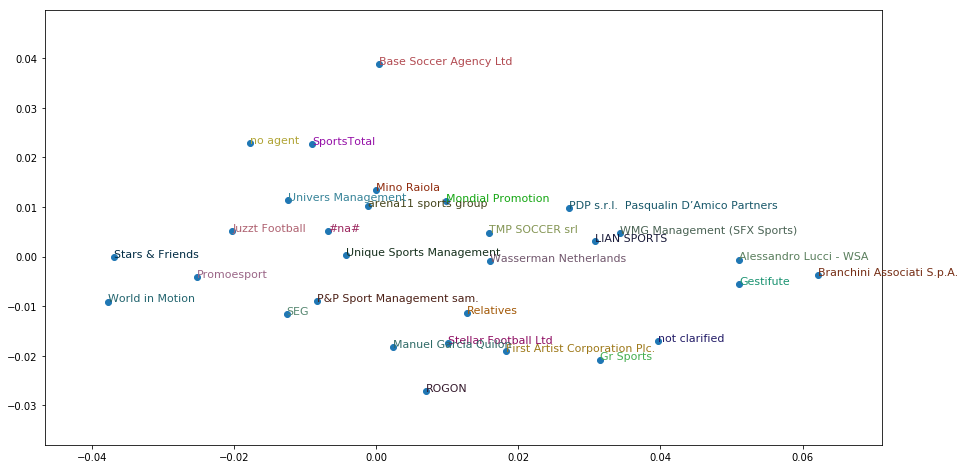

In [44]:
plot_2d_emb(emb_map=redc_emb_map, feature='plr_player_agent', top_x=30)

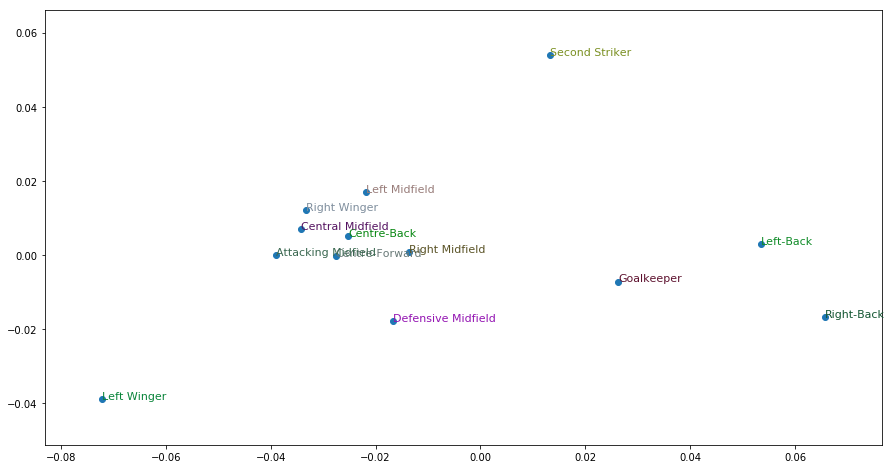

In [40]:
plot_2d_emb(emb_map=redc_emb_map, feature='plr_position_0', top_x=13)